# **Download**

In [ ]:
!pip install git+https://github.com/pcahan1/oneSC.git@cscb24
!pip install scanpy
!pip install git+https://github.com/CahanLab/PySingleCellNet
!pip install igraph
!pip install adjustText
!pip install -U scFates
!pip install pyslingshot

  Cloning https://github.com/pcahan1/oneSC.git (to revision cscb24) to /tmp/pip-req-build-s5aih_q4
  Running command git clone --filter=blob:none --quiet https://github.com/pcahan1/oneSC.git /tmp/pip-req-build-s5aih_q4
  Running command git checkout -b cscb24 --track origin/cscb24
  Switched to a new branch 'cscb24'
  Branch 'cscb24' set up to track remote branch 'cscb24' from 'origin'.
  Resolved https://github.com/pcahan1/oneSC.git to commit 9b0bcef27daeab72e297ece546f57c63ed10820b
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import pySingleCellNet as pySCN
import adjustText
import onesc
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scanpy as sc
import anndata
import scipy as sp
from joblib import dump, load
import sys
import igraph as ig
from igraph import Graph
import scFates as scf
import pyslingshot as pyShot

ig.config['plotting.backend'] = 'matplotlib'
import random
random.seed(24)

#  **Data Pre-processing**

In [ ]:
# Read intial data
adata_late=sc.read_h5ad("/content/adLate_Ectoderm (1).h5ad")

# Make gene name unique
adata_late.var_names_make_unique()

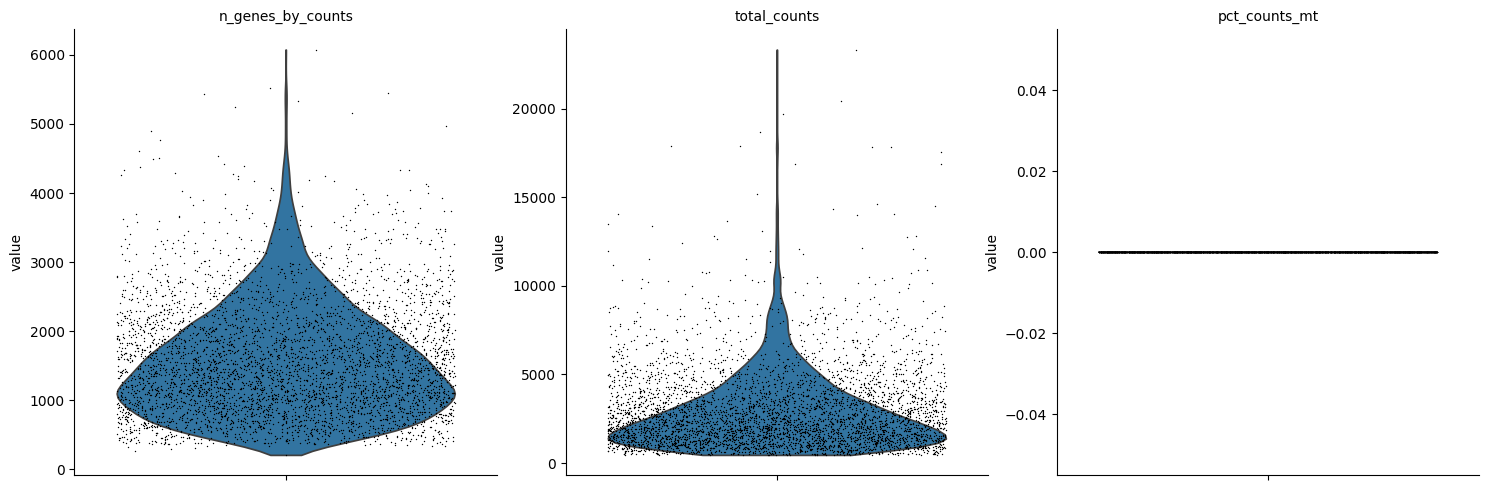

In [ ]:
# Filter out the mitochondrion data

# String match to discover mitochondrion genes
adata_late.var['mt'] = adata_late.var_names.str.startswith('MT-')

# Genes that encode for ribosomes (could be informative)
ribo_prefix = ("RPS","RPL")
adata_late.var['ribo'] = adata_late.var_names.str.startswith(ribo_prefix)

sc.pp.calculate_qc_metrics(adata_late, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_late, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:160: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


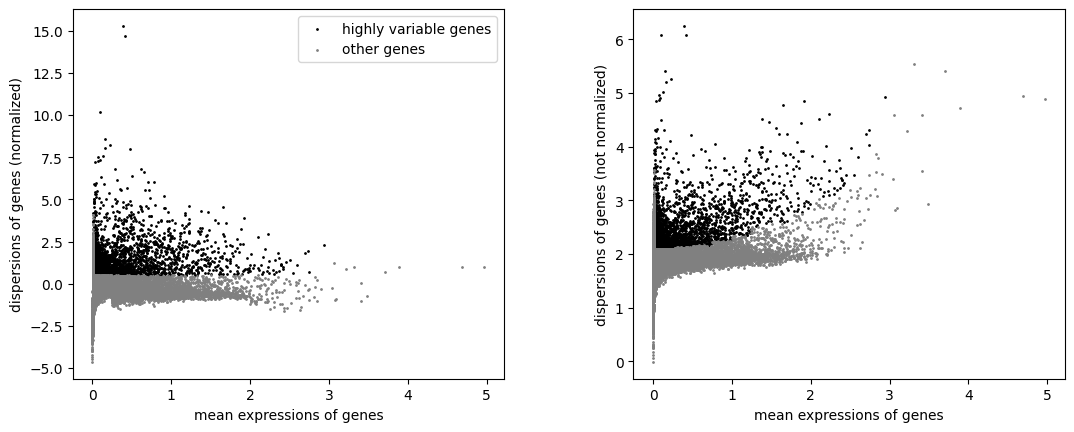

In [ ]:
# Removel mt% high cell
adata_late = adata_late[adata_late.obs.pct_counts_mt < 80, :]

# Remove mitochondria genes and ribosomal genes
non_mito_genes_list = [name for name in adata_late.var_names if not name.startswith('mt-')]
adata_late= adata_late[:, non_mito_genes_list]

non_ribo_genes_list = [name for name in adata_late.var_names if not name.startswith('Rps')]
adata_late=adata_late[:, non_ribo_genes_list]

non_ribo_genes_list = [name for name in adata_late.var_names if not name.startswith('Rpl')]
adata_late= adata_late[:, non_ribo_genes_list]

# Filter low quality gene and cells
sc.pp.filter_cells(adata_late, min_genes=100)
sc.pp.filter_cells(adata_late, max_genes=5500)
sc.pp.filter_cells(adata_late, max_counts=35000)
sc.pp.filter_genes(adata_late, min_cells=3)

# Normalization
sc.pp.normalize_total(adata_late, target_sum=1e4)
sc.pp.log1p(adata_late)

# HVG
sc.pp.highly_variable_genes(adata_late,min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_late)
adata_late = adata_late[:, adata_late.var['highly_variable']]

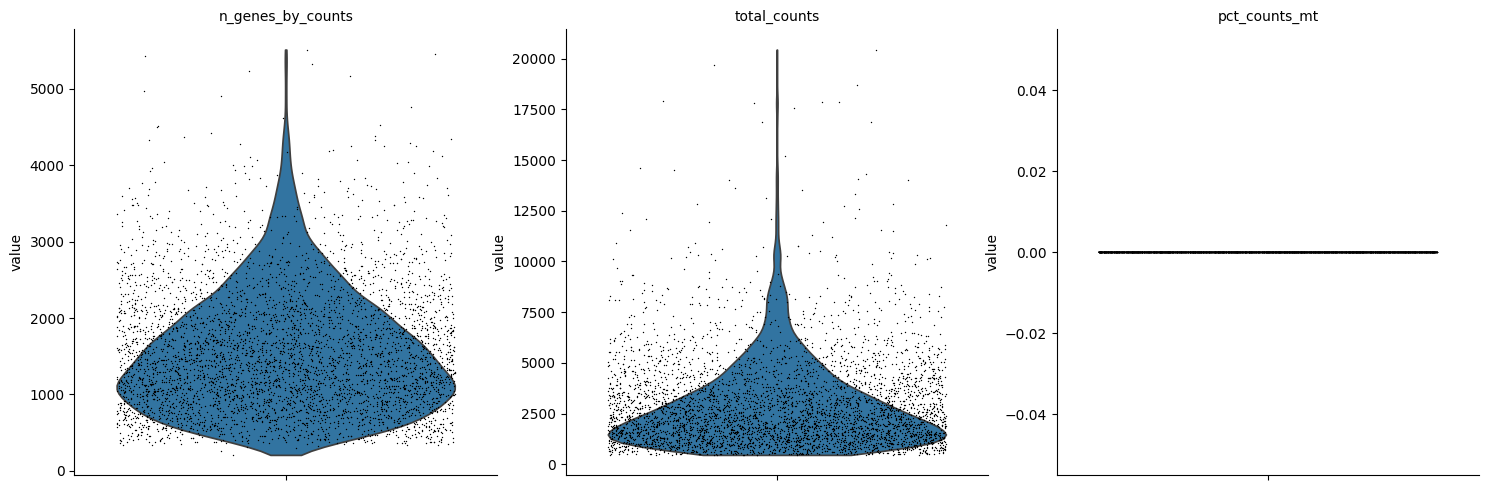

In [ ]:
adata_late_clean = adata_late.copy()
sc.pl.violin(adata_late, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


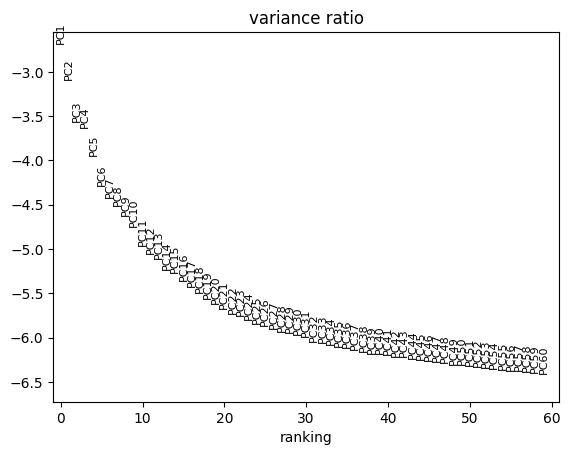

In [ ]:
# Find PCA features and compute embedding
sc.tl.pca(adata_late, n_comps=60, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_late, 60, log=True)

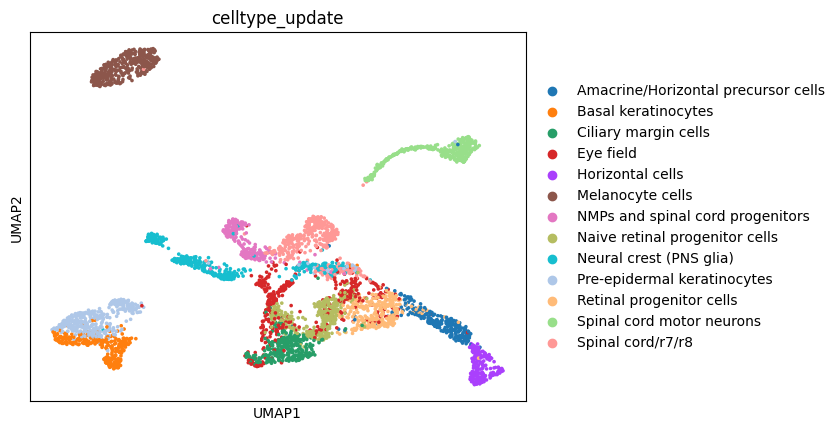

In [ ]:
# KNN, displace all cell types given in late adata

sc.pp.neighbors(adata_late, n_neighbors=60, n_pcs=20)
sc.tl.leiden(adata_late, resolution=.5)
sc.tl.umap(adata_late, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(adata_late, color=['celltype_update'])

# **TI Pre-epidermal keratinocytes -> Basal keratinocyte**

In [ ]:
# Filter data for Pre-epidermal keratinocytes to possible cell types: Basal keratinocyte

desired_cell_types = ["Pre-epidermal keratinocytes", "Basal keratinocytes"]
mask = adata_late.obs['celltype_update'].isin(desired_cell_types)
filtered_adata = adata_late[mask]

In [ ]:
# Redo PCA
sc.tl.pca(filtered_adata, n_comps=60, svd_solver='arpack')
sc.tl.pca(filtered_adata, n_comps= 60, svd_solver='arpack')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


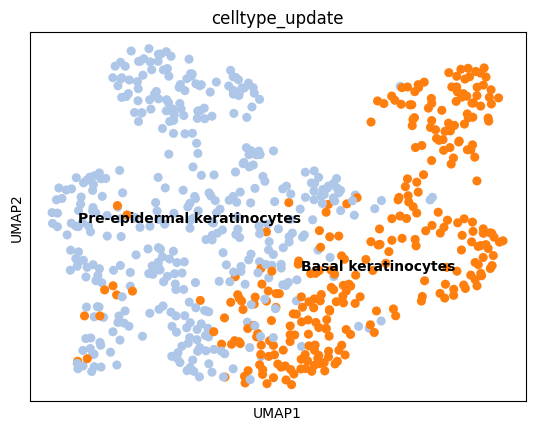

In [ ]:
# KNN

sc.pp.neighbors(filtered_adata, n_neighbors= 20, n_pcs=25)
sc.tl.leiden(filtered_adata, resolution=.5)
sc.tl.umap(filtered_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(filtered_adata, color=['celltype_update'],legend_loc='on data')

inferring a principal tree --> parameters used 
    10 principal points, sigma = 1, lambda = 25, metric = euclidean
    fitting:  10%|▉         | 19/200 [00:00<00:01, 135.65it/s]
    converged
    finished (0:00:00) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


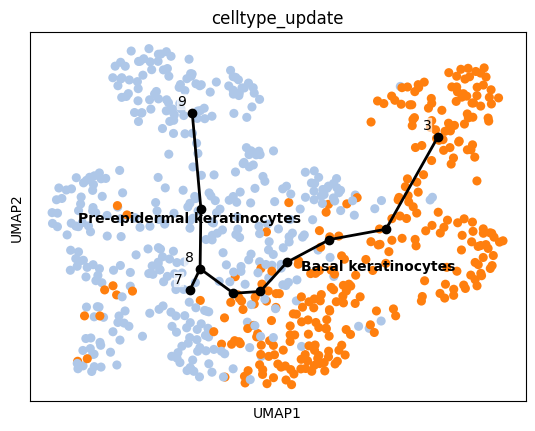

In [ ]:
# scFate tree analysis

scf.tl.tree(filtered_adata, method="ppt", device="cpu", Nodes = 10, use_rep="X_pca", seed=1,ppt_lambda=25,ppt_sigma=1,ppt_nsteps=200)
scf.pl.graph(filtered_adata, color_cells = 'celltype_update', legend_loc='on data')

In [ ]:
scf.tl.cleanup(filtered_adata, minbranchlength=2, leaves=None, copy=False)

    graph cleaned --> removed 1 principal points


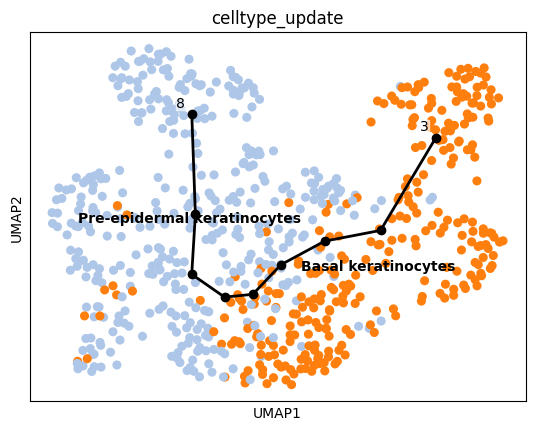

In [ ]:
scf.pl.graph(filtered_adata, color_cells = 'celltype_update', legend_loc='on data')

In [ ]:
# set root to epiblast cluster

scf.tl.root(filtered_adata, 8) # assigns pseudotime to principal points
scf.tl.pseudotime(filtered_adata) # assigns to each cell a pseudotime value, a segment, and a milestone.

node 8 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


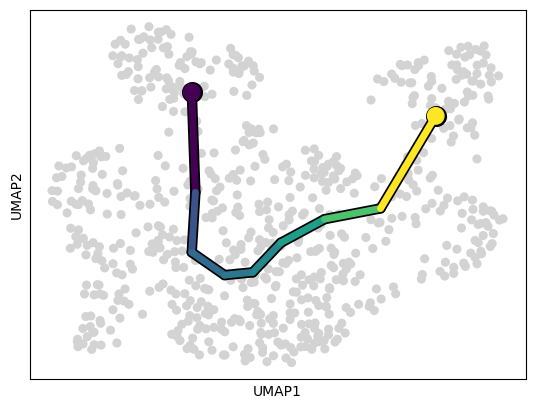

In [ ]:
scf.pl.trajectory(filtered_adata, basis = 'umap')

# **DEG**

In [ ]:
# filter out only TF genes

adata_flitered_TF = filtered_adata.copy()
adata_flitered_TF.var_names

# Read gene names from the text file
file_path = '/content/allTFs_mm_aertslab_011924.txt' # Update with your file path
with open(file_path, 'r') as file:
    file_gene_names = [line.strip() for line in file]

# Assuming 'adata.var_names' contains your current gene names
# Extract gene names from 'adata'
adata_gene_names = list(adata_flitered_TF.var_names)

# Find the intersection of gene names
overlap_genes = set(file_gene_names).intersection(set(adata_gene_names))

# Subset 'adata' to keep only the overlapping genes
adata_flitered_TF = adata_flitered_TF[:, list(overlap_genes)]

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


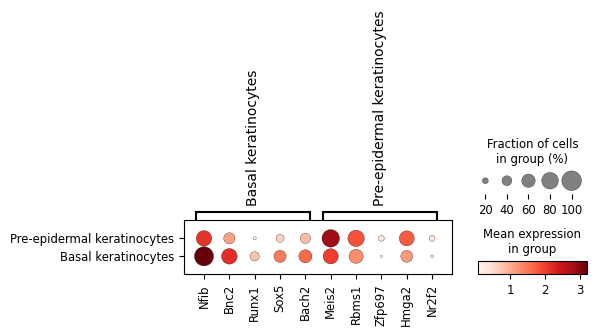

In [ ]:
# Differentia gene expression

sc.tl.rank_genes_groups(adata_flitered_TF, use_raw=False, groupby="celltype_update")
sc.pl.rank_genes_groups_dotplot(adata_flitered_TF, n_genes=5, groupby="celltype_update", dendrogram=True, key='rank_genes_groups')

In [ ]:
selected_TF = ["Nfib", "Bnc2", "Runx1", "Sox5", "Bach2",
              "Meis2", "Rbms1", "Zfp697", "Hmga2", "Nr2f2"]

In [ ]:
adata_flitered_TF = adata_flitered_TF[:,selected_TF]

# **scFate**

In [ ]:
# sub-set to hvg and TF to run and limit cells to only epiblast, mesoderm, and endoderm
adata_filtered_clean = filtered_adata.copy()

scf.tl.test_association(filtered_adata)

test features for association with the trajectory
    single mapping : 100%|██████████| 3009/3009 [04:13<00:00, 11.86it/s]
    found 144 significant features (0:04:13) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [ ]:
scf.tl.fit(filtered_adata)

fit features associated with the trajectory
    single mapping : 100%|██████████| 144/144 [00:30<00:00,  4.80it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:30) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [ ]:
scf.tl.cluster(filtered_adata)
filtered_adata.var.clusters.unique()

Clustering features using fitted layer
    finished (0:00:01) --> added 
    .var['clusters'] identified modules.


['2', '1', '0', '3']
Categories (4, object): ['0', '1', '2', '3']

In [ ]:
# filter out only TF genes
adata_flitered_TF = filtered_adata.copy()
adata_flitered_TF.var_names

# Read gene names from the text file
file_path = '/content/allTFs_mm_aertslab_011924.txt' # Update with your file path
with open(file_path, 'r') as file:
    file_gene_names = [line.strip() for line in file]

# Assuming 'adata.var_names' contains your current gene names
# Extract gene names from 'adata'
adata_gene_names = list(adata_flitered_TF.var_names)

# Find the intersection of gene names
overlap_genes = set(file_gene_names).intersection(set(adata_gene_names))

# Subset 'adata' to keep only the overlapping genes
adata_flitered_TF = adata_flitered_TF[:, list(overlap_genes)]

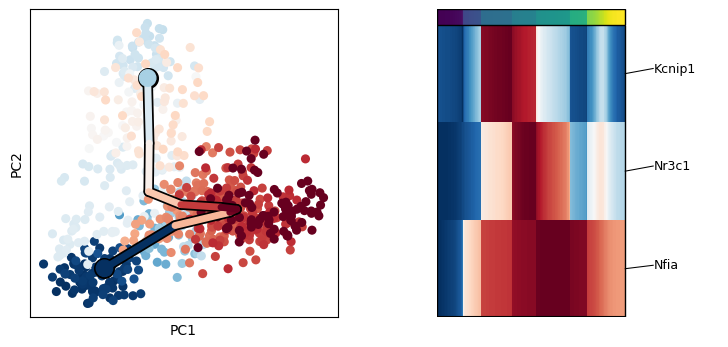

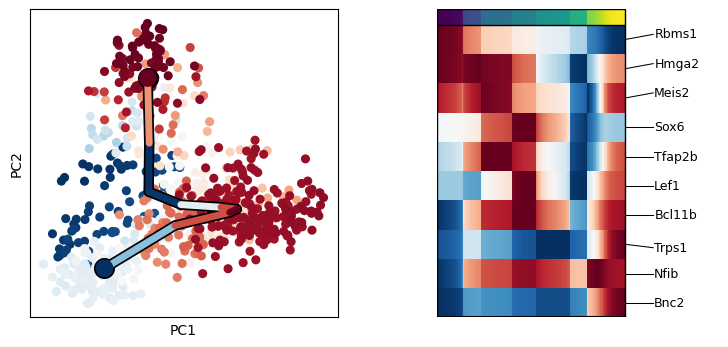

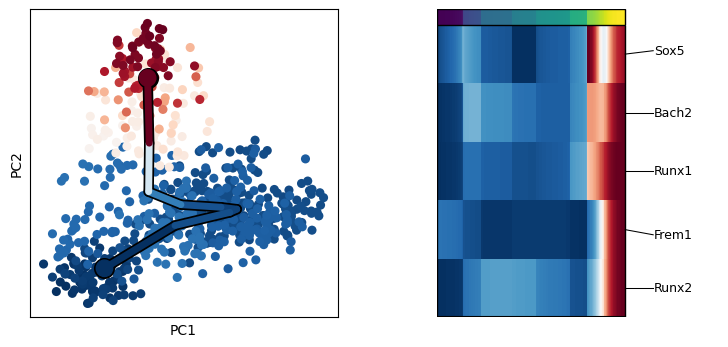

In [ ]:
for c in adata_flitered_TF.var["clusters"].unique():
    scf.pl.trends(adata_flitered_TF,features = adata_flitered_TF.var_names[adata_flitered_TF.var.clusters == c],basis="pca")

# **OneSC**

/usr/local/lib/python3.10/dist-packages/pySingleCellNet/utils.py:779: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cellid"] = adata.obs.index
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Basal keratinocytes : 
300
Pre-epidermal keratinocytes : 
400


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/usr/local/lib/python3.10/dist-packages/pySingleCellNet/rank_class.py:46: ImplicitModificationWarning: Setting element `.obsm['SCN_score']` of view, initializing view as actual.
  adata.obsm['SCN_score'] = xans.copy()
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


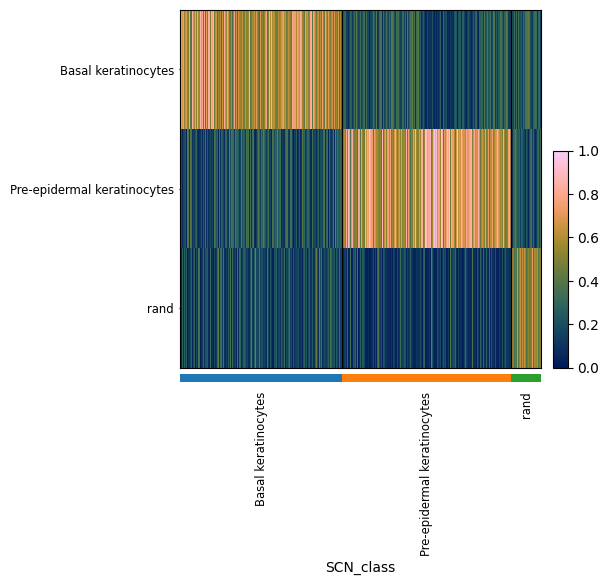

In [ ]:
# set pySCN

adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(adata_flitered_TF, ncells= 100,dLevel="celltype_update")
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel="celltype_update")

pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

In [ ]:
initial_clusters = ['Pre-epidermal keratinocytes']
end_clusters = ["Basal keratinocytes"]

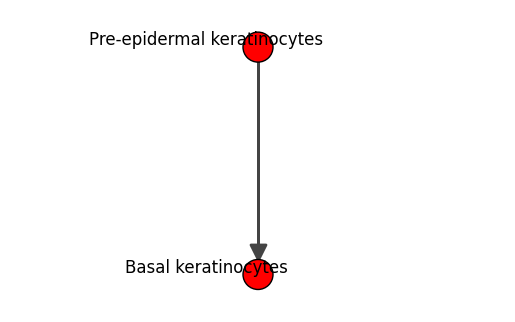

In [ ]:
state_path = onesc.construct_cluster_graph_adata(adata_flitered_TF,
                                                 initial_clusters = initial_clusters,
                                                 terminal_clusters = end_clusters,
                                                 cluster_col = "celltype_update",
                                                 pseudo_col = "t")
onesc.plot_state_graph(state_path)

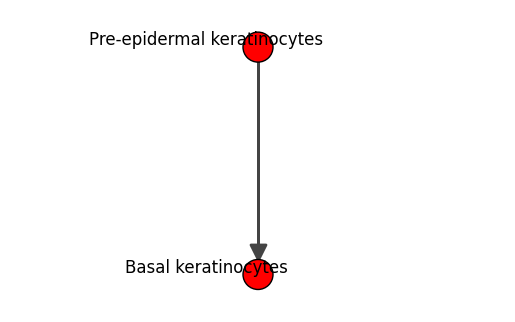

In [ ]:
edge_list = [("Pre-epidermal keratinocytes", "Basal keratinocytes")]
H = nx.DiGraph(edge_list)
onesc.plot_state_graph(H)

Preparing states and data for GA ...
Starting network reconstruction with GA ...


/usr/local/lib/python3.10/dist-packages/onesc/genetic_algorithm_GRN_trimming.py:821: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(cpu_count()))
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GRN reconstruction complete.


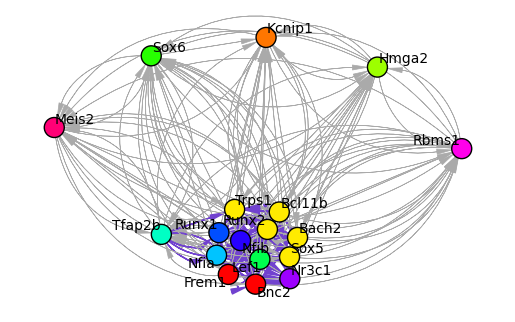

In [ ]:
start_end_states = {'start': ['Pre-epidermal keratinocytes'], 'end':["Basal keratinocytes"]}

iGRN = onesc.infer_grn(H,
                       start_end_states,
                       adata_flitered_TF,
                       num_generations = 20,
                       sol_per_pop = 30,
                       reduce_auto_reg=True,
                       ideal_edges = 0,
                       GA_seed_list = [1, 3],
                       init_pop_seed_list = [21, 25],
                       cluster_col='celltype_update',
                       pseudoTime_col='t')

grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)

# **KO**

In [ ]:
# subset gene to selected TF list
adata_start = adata_flitered_TF[adata_flitered_TF.obs['celltype_update'] == 'Pre-epidermal keratinocytes', :]

# make gene expression to boolean expression
xstates = onesc.define_states_adata(adata_start)

In [ ]:
# set up simulator
netname = 'keradiff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)

## **Nfib OE: Basal Kera. enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Nfib'] = 1
simlist_Nfib_oe = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

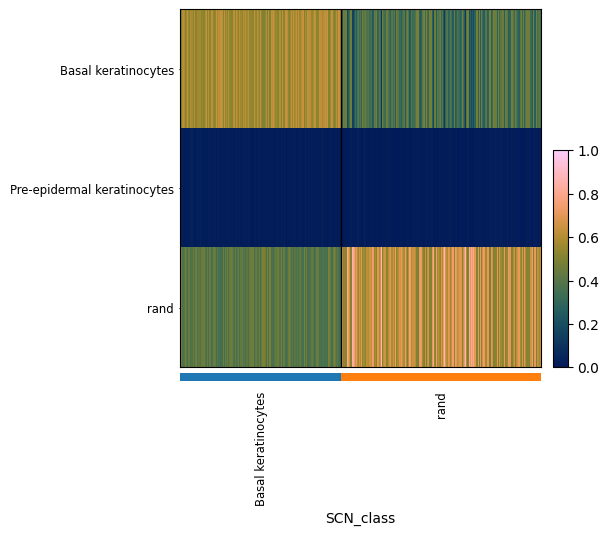

In [ ]:
ad_Nfib_oe = onesc.sample_and_compile_anndatas(simlist_Nfib_oe, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Nfib_oe, clf)
pySCN.heatmap_scores(ad_Nfib_oe, groupby = 'SCN_class')

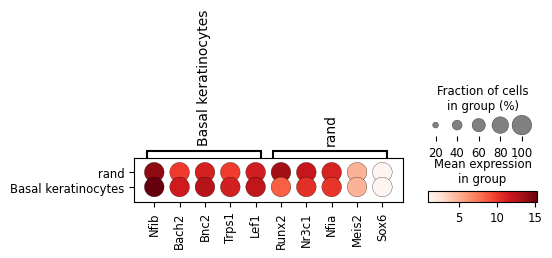

In [ ]:
sc.tl.rank_genes_groups(ad_Gsc_ko, use_raw=False, groupby="SCN_class")
sc.pl.rank_genes_groups_dotplot(ad_Gsc_ko, n_genes=5, groupby="SCN_class", dendrogram=True, key='rank_genes_groups')

## **Bnc2 OE: Basal Kera. enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Bnc2'] = 1
simlist_Bnc2_oe = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

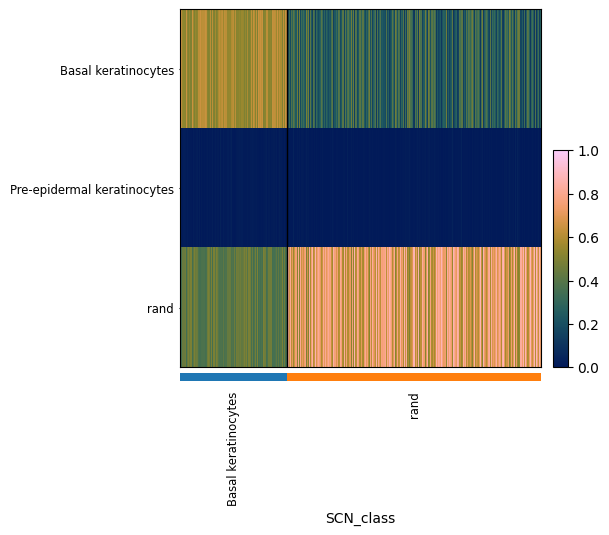

In [ ]:
ad_Bnc2_oe = onesc.sample_and_compile_anndatas(simlist_Bnc2_oe, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Bnc2_oe, clf)
pySCN.heatmap_scores(ad_Bnc2_oe, groupby = 'SCN_class')

## **Meis2 KO: Basal Kera. enriched TF**

In [ ]:
perturb_dict = dict()
perturb_dict['Meis2'] = -1
Meis2 = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)


/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

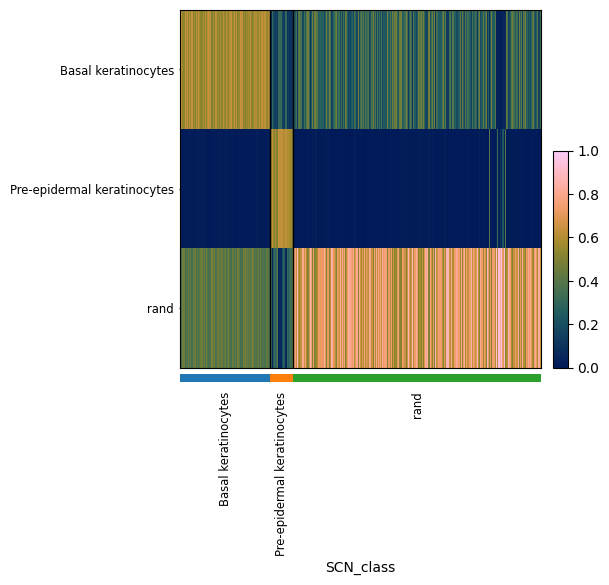

In [ ]:
ad_Meis2_ko = onesc.sample_and_compile_anndatas(simlist_Meis2_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Meis2_ko, clf)
pySCN.heatmap_scores(ad_Meis2_ko, groupby = 'SCN_class')

## **Signaling Pathway Reasoning**

**Nfib**: Role of NFIB in Keratinocyte Development
Cell Differentiation: NFIB is essential in the differentiation process of keratinocytes, the predominant cell type in the epidermis. It helps regulate the expression of genes necessary for the maturation and function of these cells. By influencing the transcription of keratin genes, NFIB contributes to the structural and functional integrity of the skin.Proliferation and Growth Control: NFIB can influence the proliferation rates of keratinocytes. Proper expression levels of NFIB are necessary to ensure a balanced cellular turnover, which is crucial during skin formation and repair.Epidermal Barrier Formation: During embryonic skin development, NFIB plays a role in the formation of the epidermal barrier. This barrier is critical for protecting the body from environmental stresses and pathogens. NFIB influences the expression of proteins involved in barrier formation and function, including various keratins and other structural proteins.

Chang, C. Y., Pasolli, H. A., Giannopoulou, E. G., Guasch, G., Gronostajski, R. M., Elemento, O., & Fuchs, E. (2013). NFIB is a governor of epithelial-melanocyte stem cell behaviour in a shared niche. Nature, 495(7439), 98–102. https://doi.org/10.1038/nature11847

**BNC2**: he NFIB gene encodes a member of the nuclear factor I (NFI) family of transcription factors, which play crucial roles in cell differentiation, proliferation, apopstosis and development. In the context of embryonic development, particularly for keratinocytes, NFIB has specific and significant functions. Here’s an overview of its role:
Bobowski-Gerard, M., Boulet, C., Zummo, F. P., Dubois-Chevalier, J., Gheeraert, C., Bou Saleh, M., Strub, J. M., Farce, A., Ploton, M., Guille, L., Vandel, J., Bongiovanni, A., Very, N., Woitrain, E., Deprince, A., Lalloyer, F., Bauge, E., Ferri, L., Ntandja-Wandji, L. C., Cotte, A. K., … Eeckhoute, J. (2022). Functional genomics uncovers the transcription factor BNC2 as required for myofibroblastic activation in fibrosis. Nature communications, 13(1), 5324. https://doi.org/10.1038/s41467-022-33063-9

BNC2 basonuclin zinc finger protein 2 [ (human)]

Basonuclin-2 regulates extracellular matrix production and degradation. Functional genomics uncovers the transcription factor BNC2 as required for myofibroblastic activation in fibrosis.Apr 7, 2024


**Meis2**: This gene encodes a homeobox protein belonging to the TALE ('three amino acid loop extension') family of homeodomain-containing proteins. TALE homeobox proteins are highly conserved transcription regulators, and several members have been shown to be essential contributors to developmental programs. Multiple transcript variants encoding distinct isoforms have been described for this gene. [provided by RefSeq, Jul 2008]



Wang, M., Wang, H., Wen, Y., Chen, X., Liu, X., Gao, J., Su, P., Xu, Y., Zhou, W., Shi, L., & Zhou, J. (2018). MEIS2 regulates endothelial to hematopoietic transition of human embryonic stem cells by targeting TAL1. Stem cell research & therapy, 9(1), 340. https://doi.org/10.1186/s13287-018-1074-z



# **Maturation**

In [ ]:
import scanpy as sc
import numpy as np
import scipy.sparse
from scipy.stats import ttest_ind

def compare_gene_expression(adata1, adata2, gene_name):
    """
    Compares the expression of a specific gene between two AnnData objects using a t-test.

    Parameters:
    adata1 (AnnData): The first AnnData object.
    adata2 (AnnData): The second AnnData object.
    gene_name (str): The name of the gene to compare.

    Returns:
    dict: A dictionary containing the mean expressions, t-test statistic, and p-value.
    """
    # Check if gene_name is present in both datasets
    if gene_name in adata1.var_names and gene_name in adata2.var_names:
        gene_index1 = adata1.var_names.get_loc(gene_name)
        gene_index2 = adata2.var_names.get_loc(gene_name)

        # Extract the expression values for the gene
        gene_expression1 = adata1.X[:, gene_index1]
        gene_expression2 = adata2.X[:, gene_index2]

        # Convert to dense format if the data is stored in a sparse format
        if scipy.sparse.issparse(gene_expression1):
            gene_expression1 = gene_expression1.toarray().flatten()
        else:
            gene_expression1 = gene_expression1.flatten()

        if scipy.sparse.issparse(gene_expression2):
            gene_expression2 = gene_expression2.toarray().flatten()
        else:
            gene_expression2 = gene_expression2.flatten()

        # Perform a t-test
        stat, p_value = ttest_ind(gene_expression1, gene_expression2, equal_var=False)  # Welch's t-test for unequal variances

        return {
            "mean_expression_adata1": np.mean(gene_expression1),
            "mean_expression_adata2": np.mean(gene_expression2),
            "t_test_statistic": stat,
            "p_value": p_value
        }
    else:
        raise ValueError(f"Gene '{gene_name}' not found in both datasets.")



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse

def create_heatmap(adata1, adata2, genes_list, condition_names=('Condition 1', 'Condition 2')):
    """
    Creates a heatmap of selected genes across two different conditions represented by two AnnData objects,
    matching the number of cells to the minimum found in either dataset for each gene.

    Parameters:
    adata1 (AnnData): AnnData object for condition 1.
    adata2 (AnnData): AnnData object for condition 2.
    genes_list (list): List of gene names to be visualized.
    condition_names (tuple): A tuple containing the names of the conditions.

    Returns:
    None
    """
    # Initialize DataFrame for gene expression data
    expr_data = []

    for gene in genes_list:
        if gene in adata1.var_names and gene in adata2.var_names:
            gene_index1 = adata1.var_names.get_loc(gene)
            gene_index2 = adata2.var_names.get_loc(gene)

            # Get expression data, convert sparse matrix if necessary
            expr1 = adata1.X[:, gene_index1].toarray().flatten() if scipy.sparse.issparse(adata1.X[:, gene_index1]) else adata1.X[:, gene_index1].flatten()
            expr2 = adata2.X[:, gene_index2].toarray().flatten() if scipy.sparse.issparse(adata2.X[:, gene_index2]) else adata2.X[:, gene_index2].flatten()

            # Adjust lengths to match the shorter dataset
            min_length = min(len(expr1), len(expr2))
            expr1 = expr1[:min_length]
            expr2 = expr2[:min_length]

            # Append data to list
            expr_data.append(pd.Series(expr1, name=(gene, condition_names[0])))
            expr_data.append(pd.Series(expr2, name=(gene, condition_names[1])))

    # Combine all series into a single DataFrame along columns
    df = pd.concat(expr_data, axis=1)

    # Check if the DataFrame is empty
    if df.empty:
        print("No valid gene data available for the provided genes.")
        return

    # Create heatmap
    plt.figure(figsize=(10, len(genes_list) * 0.5))
    sns.heatmap(df.T, cmap='viridis', yticklabels=True, xticklabels=False, cbar_kws={'label': 'Expression level'})
    plt.title('Gene Expression Comparison Across Conditions')
    plt.ylabel('Gene and Condition')
    plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gene_comparison(stats_list):
    """
    Plots a comparison of mean gene expression levels for several genes, each with wild type and perturbation statistics,
    and annotates with the t-test results. Adjusts figure size and text placement to enhance readability.

    Parameters:
    stats_list (list): List of dictionaries for each gene, where each dictionary contains:
                       - 'gene': Name of the gene
                       - 'wild_type': Mean expression level for the wild type
                       - 'perturbation': Mean expression level for the perturbation
                       - 't_test_statistic': T-test statistic for the comparison
                       - 'p_value': P-value for the comparison
    """
    # Number of genes
    num_genes = len(stats_list)

    # Data for plotting
    labels = [gene['gene'] for gene in stats_list]
    wild_means = [gene['wild_type'] for gene in stats_list]
    pert_means = [gene['perturbation'] for gene in stats_list]
    t_stats = [gene['t_test_statistic'] for gene in stats_list]
    p_vals = [gene['p_value'] for gene in stats_list]

    # Bar positions
    x = np.arange(num_genes)
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 8))  # Increase the figure size
    rects1 = ax.bar(x - width/2, wild_means, width, label='Wild Type')
    rects2 = ax.bar(x + width/2, pert_means, width, label='Perturbation')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Expression Levels')
    ax.set_title('Gene Expression by Type and Condition')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Attach a text label above each bar for t-test statistics and p-values
    for i, (rect1, rect2) in enumerate(zip(rects1, rects2)):
        height = max(rect1.get_height(), rect2.get_height())
        ax.annotate(f'T-stat: {t_stats[i]:.2f}\nP-val: {p_vals[i]:.2e}',
                    xy=(rect1.get_x() + rect1.get_width(), height),
                    xytext=(15, 0),  # Adjusted offset to move text up
                    textcoords="offset points",
                    ha='right', va='bottom',
                    fontsize=10)  # Adjust font size

    plt.show()

According to internet, the maturation markers for basal keratinocytes are:

Krt5, Krt14, Krt10

In [ ]:
selected_TF = ["Nfib", "Bnc2", "Runx1", "Sox5", "Bach2",
               "Meis2", "Rbms1", "Zfp697", "Hmga2", "Nr2f2",
               "Krt5", "Krt14", "Krt10" ]

filtered_adata = filtered_adata[:,selected_TF]

/usr/local/lib/python3.10/dist-packages/pySingleCellNet/utils.py:779: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cellid"] = adata.obs.index
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


Pre-epidermal keratinocytes : 
400
Basal keratinocytes : 
300


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:134: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/usr/local/lib/python3.10/dist-packages/pySingleCellNet/rank_class.py:46: ImplicitModificationWarning: Setting element `.obsm['SCN_score']` of view, initializing view as actual.
  adata.obsm['SCN_score'] = xans.copy()
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


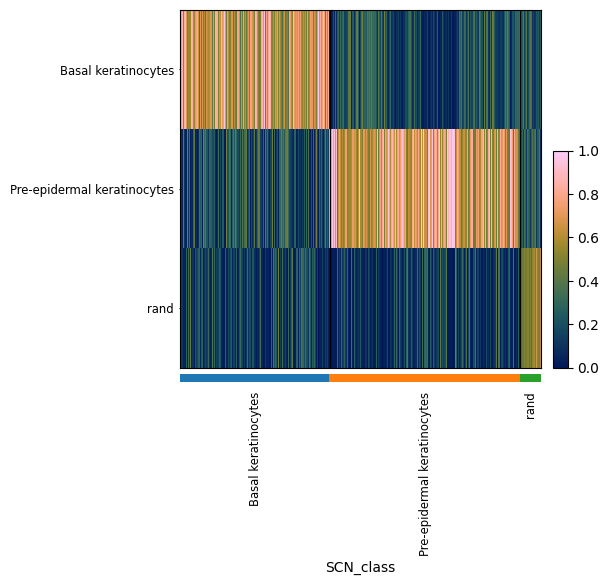

In [ ]:
# set pySCN

adTrain_rank, adHeldOut_rank = pySCN.splitCommonAnnData(filtered_adata, ncells= 100,dLevel="celltype_update")
clf = pySCN.train_rank_classifier(adTrain_rank, dLevel="celltype_update")

pySCN.rank_classify(adHeldOut_rank, clf)
pySCN.heatmap_scores(adHeldOut_rank, groupby='SCN_class')

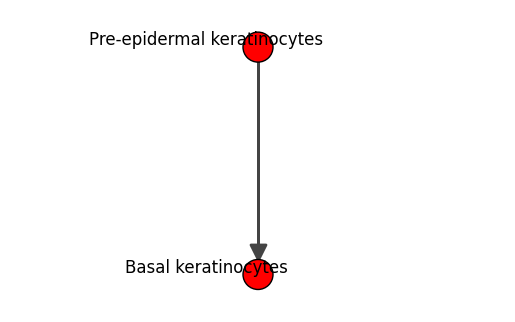

In [ ]:
initial_clusters = ['Pre-epidermal keratinocytes']
end_clusters = ["Basal keratinocytes"]

state_path = onesc.construct_cluster_graph_adata(filtered_adata,
                                                 initial_clusters = initial_clusters,
                                                 terminal_clusters = end_clusters,
                                                 cluster_col = "celltype_update",
                                                 pseudo_col = "t")
onesc.plot_state_graph(state_path)

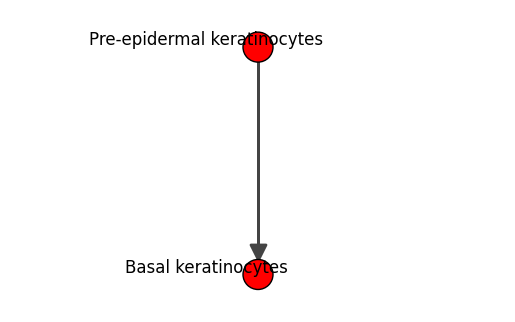

In [ ]:
edge_list = [("Pre-epidermal keratinocytes", "Basal keratinocytes")]
H = nx.DiGraph(edge_list)
onesc.plot_state_graph(H)

Preparing states and data for GA ...
Starting network reconstruction with GA ...


/usr/local/lib/python3.10/dist-packages/onesc/genetic_algorithm_GRN_trimming.py:821: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(cpu_count()))
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GRN reconstruction complete.


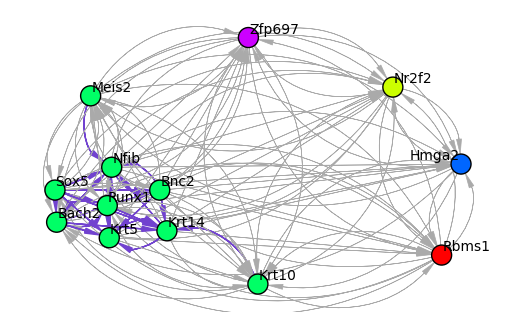

In [ ]:
start_end_states = {'start': ['Pre-epidermal keratinocytes'], 'end':["Basal keratinocytes"]}



iGRN = onesc.infer_grn(H,
                       start_end_states,
                       filtered_adata,
                       num_generations = 20,
                       sol_per_pop = 30,
                       reduce_auto_reg=True,
                       ideal_edges = 0,
                       GA_seed_list = [1, 3],
                       init_pop_seed_list = [21, 25],
                       cluster_col='celltype_update',
                       pseudoTime_col='t')

grn_ig = onesc.dataframe_to_igraph(iGRN)
onesc.plot_grn(grn_ig, layout_method='fr',community_first=True)

In [ ]:
# subset gene to selected TF list
adata_start = filtered_adata[filtered_adata.obs['celltype_update'] == 'Pre-epidermal keratinocytes', :]

# make gene expression to boolean expression
xstates = onesc.define_states_adata(adata_start)

In [ ]:
# set up simulator
netname = 'keradiff'
netsim = onesc.network_structure()
netsim.fit_grn(iGRN)
sim = onesc.OneSC_simulator()
sim.add_network_compilation(netname, netsim)

## Wild Type

In [ ]:
simlist_wt = onesc.simulate_parallel_adata(sim, xstates, netname, n_cores = 8, num_sim = 1000, num_runs = 32, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

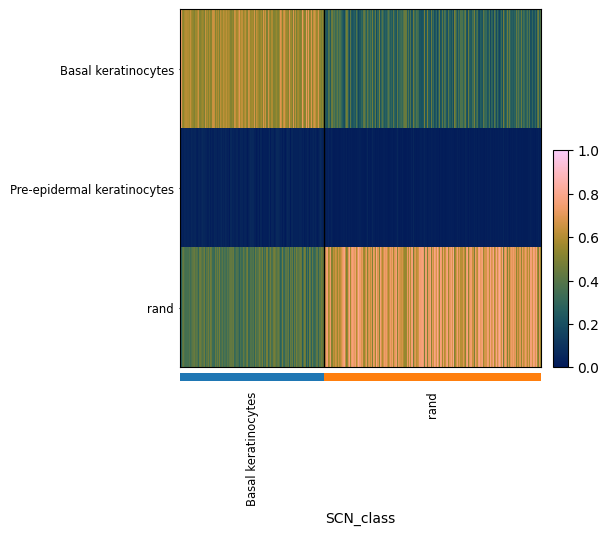

In [ ]:
ad_wt = onesc.sample_and_compile_anndatas(simlist_wt, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_wt, clf)
pySCN.heatmap_scores(ad_wt, groupby = 'SCN_class')

## SOX5 KO

Sox5 and Sox6 promote the development of a highly proliferating pool of chondroblasts between the epiphyses and metaphyses of future long bones. This pool is the likely cellular source of growth plates.


The Wnt/ βcatenin signaling pathway controls specification of dp/dI1-3 progenitors and interneurons.



In [ ]:
perturb_dict = dict()
perturb_dict['Sox5'] = -1
simlist_Sox5_ko = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

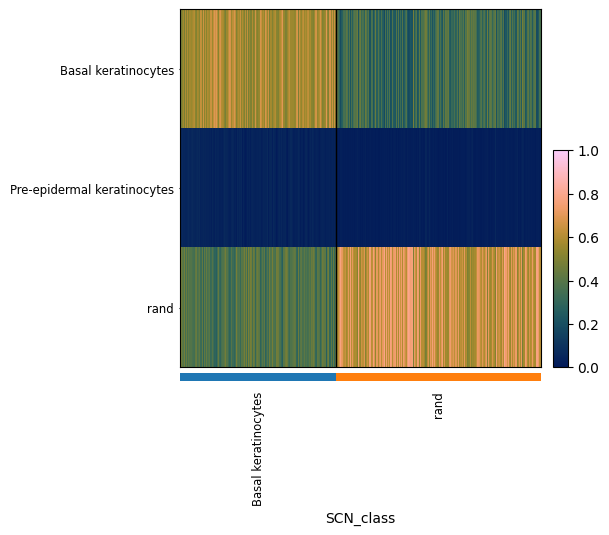

In [ ]:
ad_Sox5_ko = onesc.sample_and_compile_anndatas(simlist_Sox5_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Sox5_ko, clf)
pySCN.heatmap_scores(ad_Sox5_ko, groupby = 'SCN_class')

In [ ]:
compare_gene_expression(ad_wt, ad_Sox5_ko, 'Krt5' )

{'mean_expression_adata1': 9.144375,
 'mean_expression_adata2': 9.498,
 't_test_statistic': -3.4212706644413893,
 'p_value': 0.0006522471418213176}

In [ ]:
compare_gene_expression(ad_wt, ad_Sox5_ko, 'Krt10' )

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


{'mean_expression_adata1': 5.0,
 'mean_expression_adata2': 5.0,
 't_test_statistic': nan,
 'p_value': nan}

In [ ]:
compare_gene_expression(ad_wt, ad_Sox5_ko, 'Krt14' )

{'mean_expression_adata1': 8.995625,
 'mean_expression_adata2': 9.686,
 't_test_statistic': -7.217086711002566,
 'p_value': 1.1212002888733804e-12}

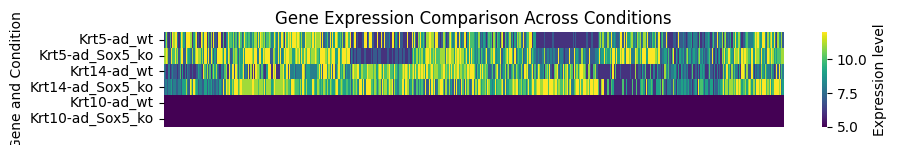

In [ ]:
genes_list = ['Krt5', 'Krt14', 'Krt10']  # List of genes you're interested in
create_heatmap(ad_wt, ad_Sox5_ko, genes_list, condition_names=('ad_wt', 'ad_Sox5_ko'))

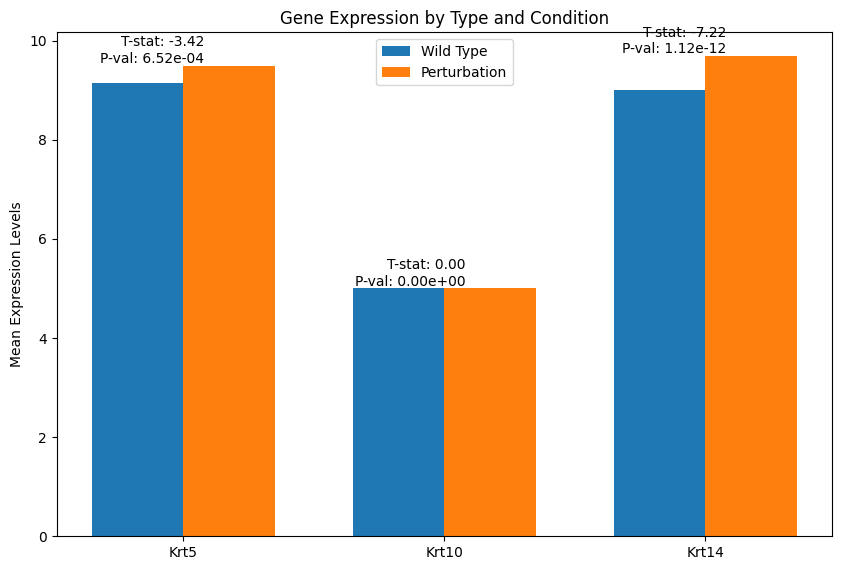

In [ ]:

stats_list = [
    {'gene': 'Krt5', 'wild_type': 9.144375, 'perturbation': 9.498, 't_test_statistic': -3.4212706644413893, 'p_value': 0.0006522471418213176},
    {'gene': 'Krt10', 'wild_type': 5.0, 'perturbation': 5.0, 't_test_statistic': 0, 'p_value': 0},
    {'gene': 'Krt14', 'wild_type':  8.995625, 'perturbation':9.686, 't_test_statistic': -7.217086711002566, 'p_value': 1.1212002888733804e-12}
]

plot_gene_comparison(stats_list)


## RUNX1 KO

Runx1: The RUNX1 gene provides instructions for making a protein called runt-related transcription factor 1 (RUNX1). Like other transcription factors, the RUNX1 protein attaches (binds) to specific regions of DNA and helps control the activity of particular genes. This protein interacts with another protein called core binding factor beta or CBFβ (produced from the CBFB gene), which helps RUNX1 bind to DNA and prevents it from being broken down. Together, these proteins form one version of a complex known as core binding factor (CBF). The RUNX1 protein turns on (activates) genes that help control the development of blood cells (hematopoiesis). In particular, it plays an important role in development of hematopoietic stem cells, early blood cells that have the potential to develop into all types of mature blood cells such as white blood cells, red blood cells, and platelets.

RUNX1 is a transcription factor that regulates multiple signaling pathways, including the Hippo/ Yap, TGFβ/Smad, and Wnt/β-catenin pathways. These pathways converge to regulate the expression of downstream genes, which controls a series of osteoarthritic pathological processes. RUNX1 is also regulated by Wnt/β-catenin, which is downstream of the Wnt pathway.

In [ ]:
perturb_dict = dict()
perturb_dict['Runx1'] = -1
simlist_Runx1_ko = onesc.simulate_parallel_adata(sim, xstates, netname, perturb_dict = perturb_dict, n_cores = 8, num_sim = 1000, t_interval = 0.1, noise_amp = 0.5)

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:238: UserWarning: Maximum number of cores is 2
  warnings.warn("Maximum number of cores is " + str(mp.cpu_count()))
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/loca

/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sampled_cells.obs['origin_adata'] = i
/usr/local/lib/python3.10/dist-packages/onesc/wrappers_plus.py:290: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as act

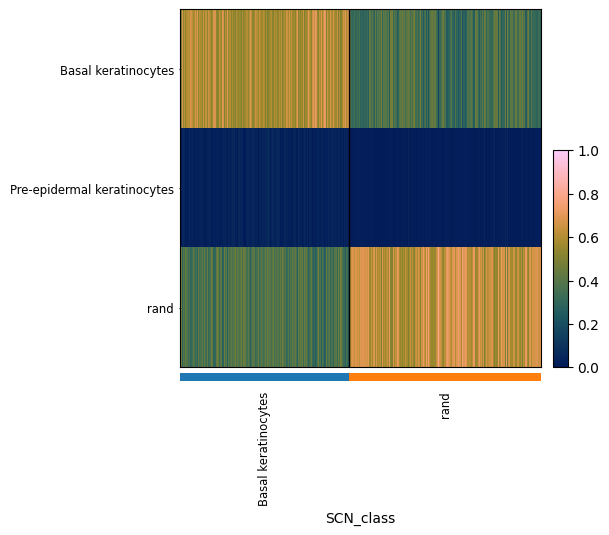

In [ ]:
ad_Runx1_ko = onesc.sample_and_compile_anndatas(simlist_Runx1_ko, X=50, time_bin=(80, 100), sequential_order_column='sim_time')
pySCN.rank_classify(ad_Runx1_ko, clf)
pySCN.heatmap_scores(ad_Runx1_ko, groupby = 'SCN_class')

In [ ]:
compare_gene_expression(ad_wt, ad_Runx1_ko, 'Krt5' )

{'mean_expression_adata1': 9.144375,
 'mean_expression_adata2': 9.32,
 't_test_statistic': -1.7360770539800858,
 'p_value': 0.08289407632802194}

In [ ]:
compare_gene_expression(ad_wt, ad_Runx1_ko, 'Krt10' )

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


{'mean_expression_adata1': 5.0,
 'mean_expression_adata2': 5.0,
 't_test_statistic': nan,
 'p_value': nan}

In [ ]:
compare_gene_expression(ad_wt, ad_Runx1_ko, 'Krt14' )

{'mean_expression_adata1': 8.995625,
 'mean_expression_adata2': 9.51,
 't_test_statistic': -5.196816722818761,
 'p_value': 2.526791276636083e-07}

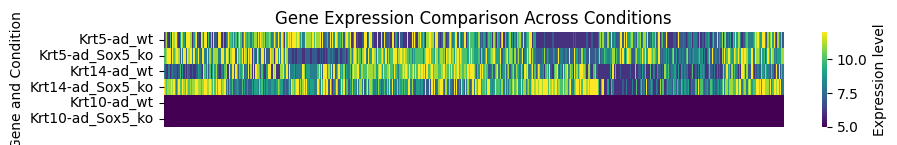

In [ ]:
 # Example usage:
genes_list = ['Krt5', 'Krt14', 'Krt10']  # List of genes you're interested in
create_heatmap(ad_wt, ad_Runx1_ko, genes_list, condition_names=('ad_wt', 'ad_Sox5_ko'))


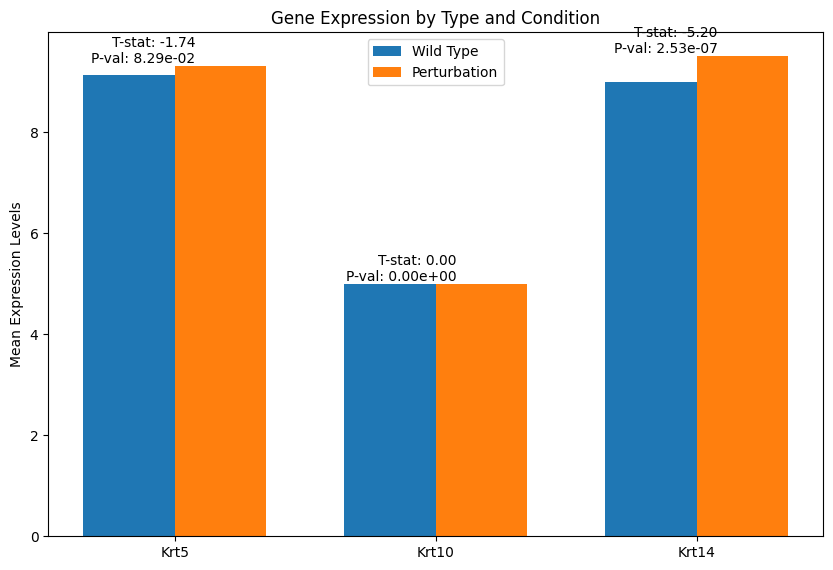

In [ ]:

stats_list = [
    {'gene': 'Krt5', 'wild_type': 9.144375, 'perturbation': 9.32, 't_test_statistic': -1.7360770539800858, 'p_value': 0.08289407632802194},
    {'gene': 'Krt10', 'wild_type': 5.0, 'perturbation': 5.0, 't_test_statistic': 0, 'p_value': 0},
    {'gene': 'Krt14', 'wild_type':   8.995625, 'perturbation':9.51, 't_test_statistic': -5.196816722818761, 'p_value': 2.526791276636083e-07}
]

plot_gene_comparison(stats_list)

In [1]:
%%shell
jupyter nbconvert --to html '/content/Pre_EpidermalKeratinocytes_to_BasalKeratinocytes_with_Maturation.ipynb'

[NbConvertApp] Converting notebook /content/Pre_EpidermalKeratinocytes_to_BasalKeratinocytes_with_Maturation.ipynb to html
[NbConvertApp] Writing 2946667 bytes to /content/Pre_EpidermalKeratinocytes_to_BasalKeratinocytes_with_Maturation.html
